In [1]:
import os
import sys
sys.path.append('/Users/david/Desktop/FinetuneEmbed')
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Specify the working directory
os.chdir('/Users/david/Desktop/FinetuneEmbed')
# os.chdir('/afs/crc.nd.edu/group/StatDataMine/dm011/Dailin_Gan/FinetuneEmbed')
llm_ls = ['GenePT_1536',
          'stella-base-en-v2',
          "biobert-base-cased-v1.1"
          ]
random_states = list(range(41, 51)) # set up the random seeds
task_ls = ['long_vs_shortTF', 'DosageSensitivity', 'MethylationState/bivalent_vs_lys4',
           'MethylationState/bivalent_vs_no_methyl']

SLLMs_root = './res/2025_0529_Truncation_4tasks'
GenePT_root = './res/2025_0529_Truncation_4tasks'
embed_type = 'name_embedding'
do_cv = "CV"
do_trun = "Truncation"
fig_num = "Fig8"


In [2]:
# create all model runs dictionary
all_model_runs = {}
for task in task_ls:
    task_dict = {}
    for classifier in ['LR', 'RF']:
        classifier_dict = {}
        for llm in llm_ls:
            runs = []
            for state in random_states:
                
                if do_cv == "CV":
                    pkl_file = f"{classifier}_CV_roc_data.pkl"
                elif do_cv == "NoCV":
                    pkl_file = f"{classifier}_roc_data.pkl"
                
                if llm == 'GenePT_1536':
                    res_path = f"{GenePT_root}/NoPCA_{do_cv}_{embed_type}_{do_trun}/{task}/{llm}/random_state_{state}/{pkl_file}"
                else:
                    res_path = f"{SLLMs_root}/NoPCA_{do_cv}_{embed_type}_{do_trun}/{task}/{llm}/random_state_{state}/{pkl_file}"
                with open(res_path, 'rb') as f:
                    run = pickle.load(f)
                runs.append(run)
            if llm == 'GenePT_1536':
                classifier_dict["OpenAI"] = runs # change the naming
            else:
                classifier_dict[llm] = runs
        task_dict[classifier] = classifier_dict
    if task == 'long_vs_shortTF':
        all_model_runs['Task_1'] = task_dict
    elif task == 'DosageSensitivity':
        all_model_runs['Task_2'] = task_dict
    elif task == 'MethylationState/bivalent_vs_lys4':
        all_model_runs['Task_3'] = task_dict
    elif task == 'MethylationState/bivalent_vs_no_methyl':
        all_model_runs['Task_4'] = task_dict


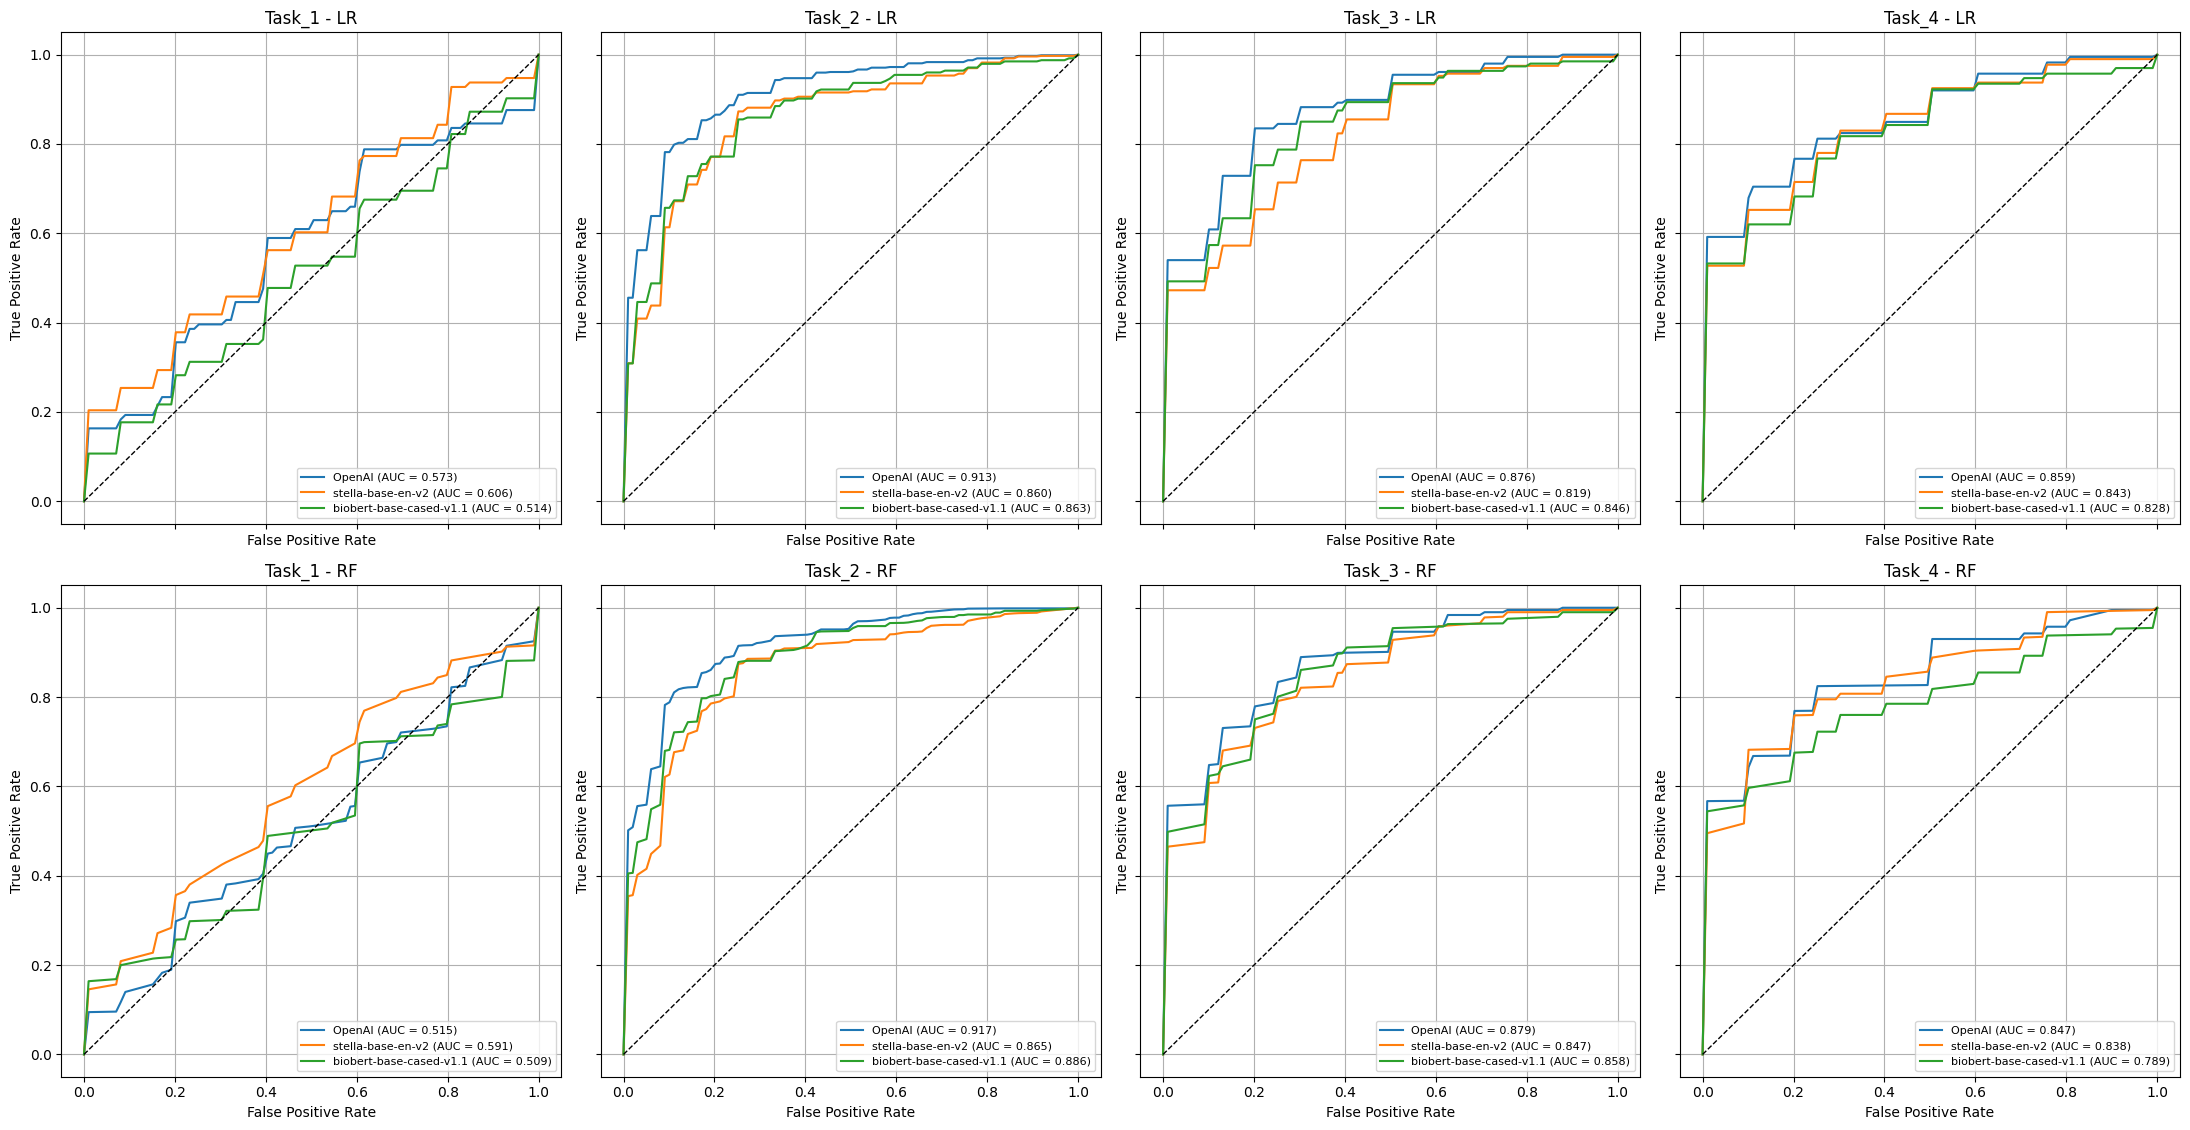

In [3]:

# Common FPR grid for interpolation
fpr_common = np.linspace(0, 1, 100)

# Set up 2 rows (classifiers) x 4 columns (tasks)
fig, axes = plt.subplots(2, 4, figsize=(22, 12), sharex=True, sharey=True)
axes = np.array(axes)

# Sort keys for consistent layout
tasks_sorted = sorted(all_model_runs.keys())
classifiers_sorted = sorted(next(iter(all_model_runs.values())).keys())

# Loop over classifiers (rows), tasks (columns)
for i_clf, clf in enumerate(classifiers_sorted):
    for i_task, task in enumerate(tasks_sorted):
        ax = axes[i_clf, i_task]
        model_runs = all_model_runs[task][clf]  # model_name -> [runs]

        for model_name, runs in model_runs.items():
            tpr_macro_all = []
            auc_macro_all = []

            for run in runs:
                y_test_bin = run["y_test_bin"]
                y_test_proba = run["y_test_proba"]

                # Ensure 2D shape for binary case
                if y_test_bin.ndim == 1 or y_test_bin.shape[1] == 1:
                    y_test_bin = np.vstack((1 - y_test_bin, y_test_bin)).T
                if y_test_proba.ndim == 1 or y_test_proba.shape[1] == 1:
                    y_test_proba = np.vstack((1 - y_test_proba, y_test_proba)).T

                n_classes = y_test_proba.shape[1]
                tpr_per_class = []
                aucs = []

                for i in range(n_classes):
                    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
                    tpr_interp = np.interp(fpr_common, fpr, tpr)
                    tpr_interp[0] = 0.0
                    tpr_per_class.append(tpr_interp)
                    aucs.append(auc(fpr, tpr))

                tpr_macro = np.mean(tpr_per_class, axis=0)
                auc_macro = np.mean(aucs)
                tpr_macro_all.append(tpr_macro)
                auc_macro_all.append(auc_macro)

            # Plot the mean ROC curve for this model
            mean_tpr = np.mean(tpr_macro_all, axis=0)
            mean_auc = np.mean(auc_macro_all)
            ax.plot(fpr_common, mean_tpr, label=f"{model_name} (AUC = {mean_auc:.3f})")

        ax.plot([0, 1], [0, 1], 'k--', lw=1)
        ax.set_title(f"{task} - {clf}", fontsize=12)
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.grid(True)

        # ✅ Add individual legend for this subplot
        ax.legend(fontsize=8, loc="lower right", ncol=1)

# Global figure settings
# fig.suptitle("Mean Macro-Average ROC Curves by Task and Classifier", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save to PDF
plt.savefig(f"./res/2025_0606_AUCPlots/{fig_num}_{do_cv}_{embed_type}_{do_trun}roc_curve.pdf", format="pdf", bbox_inches="tight")
plt.show()